In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display

import time


In [4]:
# Параметры
simulation_time = 100  # секунд
time_step = 0.1  # уменьшаем шаг времени для более плавной симуляции
num_steps = int(simulation_time / time_step)
landmarks = []  # здесь будем хранить позиции ориентиров

num_landmarks = 15
for i in range(num_landmarks):
    landmarks.append([np.random.uniform(-5, 5), np.random.uniform(-5, 5)])

# Начальная позиция и параметры
x, y, yaw = [0], [0], [0]  # Начальная позиция робота
v = 0.2  # Начальная линейная скорость (м/с)
w = 0  # Начальная угловая скорость (рад/с)
v_target = 0.2  # Целевая линейная скорость
w_target = 0  # Целевая угловая скорость

max_v = 0.6  # Максимальная линейная скорость
max_w = 0.8  # Максимальная угловая скорость
max_v_change = 0.05  # Максимальное изменение линейной скорости за шаг
max_w_change = 0.1  # Максимальное изменение угловой скорости за шаг
control_update_interval = 20  

v_history = [v]  
w_history = [w] 

timestamps = [time.time()]  # Начальное время


for i in range(1, num_steps):
    # Периодически меняем целевые скорости для имитации изменения поведения
    if i % control_update_interval == 0:

        v_target = np.clip(v_target + np.random.uniform(-0.2, 0.2), 0.1, max_v)
        w_target = np.clip(w_target + np.random.uniform(-0.3, 0.3), -max_w, max_w)
        
        # Иногда добавляем резкие повороты или остановки, имитируя реакцию на препятствия
        if np.random.random() < 0.1:  
            if np.random.random() < 0.5:
                w_target = np.random.choice([-max_w, max_w]) * 0.8  # Резкий поворот
            else:
                v_target = 0.05  # Почти остановка
    
    
    v_error = v_target - v
    w_error = w_target - w
    
    # Ограничиваем изменение скорости для реалистичности
    v_change = np.clip(v_error, -max_v_change, max_v_change)
    w_change = np.clip(w_error, -max_w_change, max_w_change)
    
    v_noise = np.random.normal(0, 0.01)
    w_noise = np.random.normal(0, 0.02)
    
    # Обновляем скорости
    v += v_change + v_noise
    w += w_change + w_noise
    
    v = np.clip(v, 0, max_v)
    w = np.clip(w, -max_w, max_w)
    
    v_history.append(v)
    w_history.append(w)
    
    dx = v * np.cos(yaw[-1]) * time_step
    dy = v * np.sin(yaw[-1]) * time_step
    dyaw = w * time_step
    
    new_x = x[-1] + dx
    new_y = y[-1] + dy
    new_yaw = yaw[-1] + dyaw
    
    slip_x = np.random.normal(0, 0.001 * v)
    slip_y = np.random.normal(0, 0.001 * v)
    
    x.append(new_x + slip_x)
    y.append(new_y + slip_y)
    yaw.append(new_yaw)
    timestamps.append(timestamps[0] + i * time_step)

groundtruth = pd.DataFrame({
    'time': timestamps, 
    'x': x, 
    'y': y, 
    'yaw': yaw
})

odometry = pd.DataFrame({
    'time': timestamps,
    'v': v_history,
    'w': w_history
})

measurements_list = []
for i, t in enumerate(timestamps):
    
    if i % 5 == 0:  # Измерения делаются через определенные интервалы
        robot_x, robot_y, robot_yaw = x[i], y[i], yaw[i]
        
        for landmark_id, landmark_pos in enumerate(landmarks):
            # Вычисляем истинное расстояние и угол до ориентира
            lm_x, lm_y = landmark_pos
            dx = lm_x - robot_x
            dy = lm_y - robot_y
            
            # Расстояние до ориентира
            true_distance = np.sqrt(dx**2 + dy**2)
            
            # Если ориентир слишком далеко, его не видно
            if true_distance > 8:
                continue
                
           
            true_angle = np.arctan2(dy, dx) - robot_yaw
            true_angle = (true_angle + np.pi) % (2 * np.pi) - np.pi  
            
           
            distance_noise = np.random.normal(0, 0.05 + 0.02 * true_distance)
            angle_noise = np.random.normal(0, 0.02 + 0.01 * true_distance)
            
            # Измеренные значения
            measured_distance = true_distance + distance_noise
            measured_angle = true_angle + angle_noise
            
           
            if np.random.random() < 0.95: 
                measurements_list.append([t, landmark_id, measured_distance, measured_angle])

measurements = pd.DataFrame(measurements_list, columns=['time', 'landmark_id', 'distance', 'angle'])


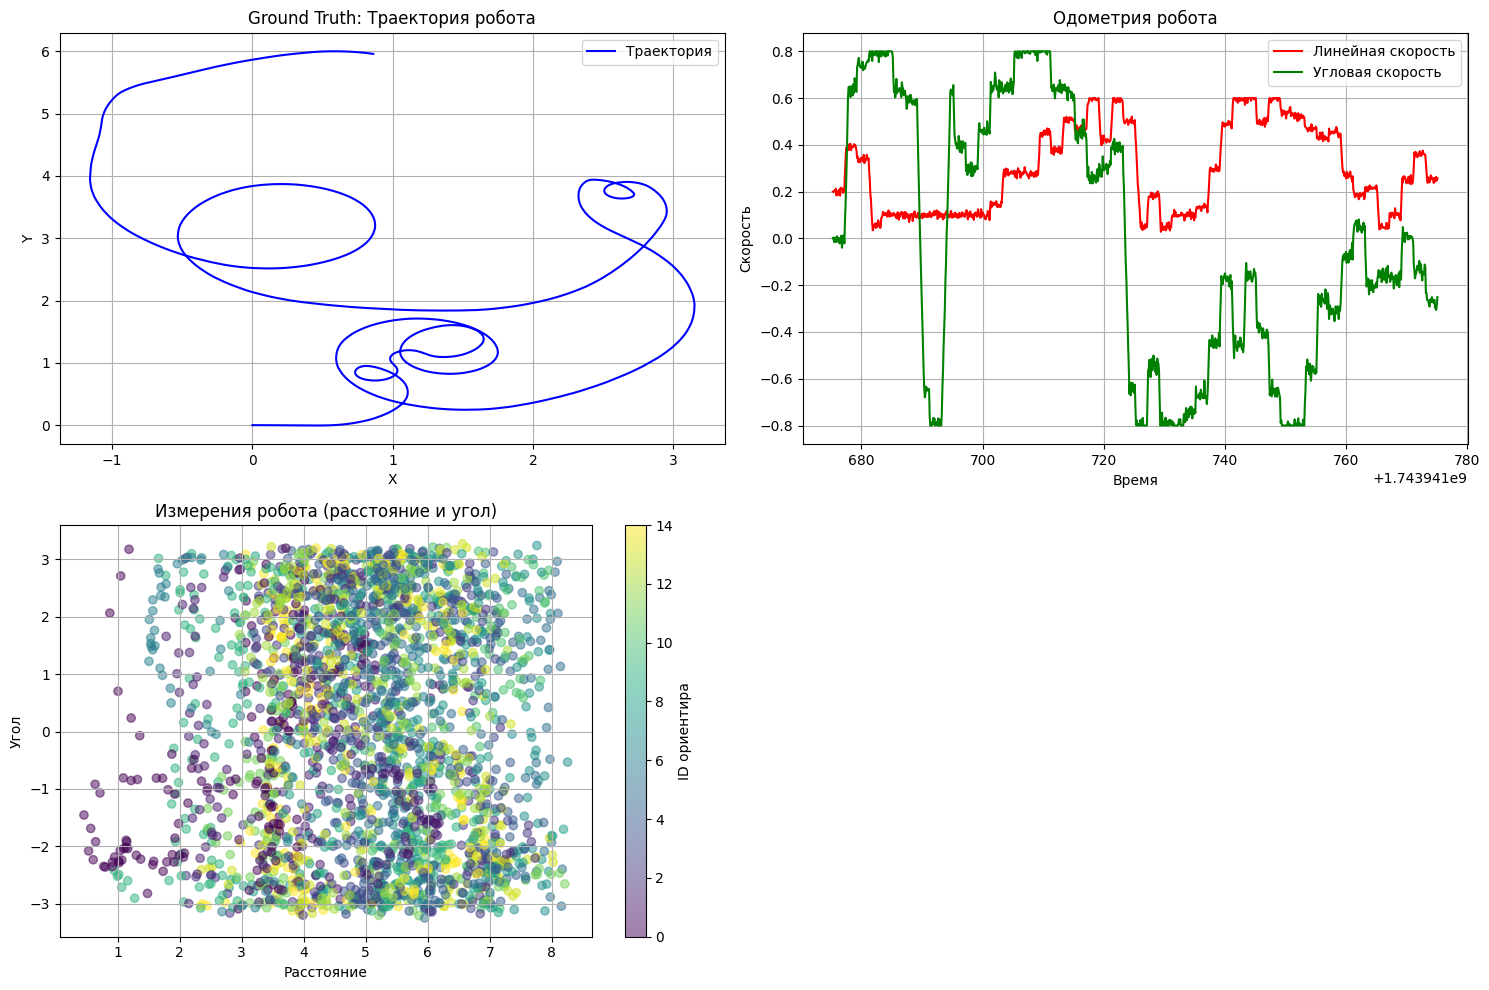

In [8]:
plt.figure(figsize=(15, 10))

# 1. Траектория (Ground Truth)
plt.subplot(2, 2, 1)
plt.plot(groundtruth["x"], groundtruth["y"], 'b-', label="Траектория")
# plt.scatter(landmark["x"], landmark["y"], c='red', marker='x', label="Ориентиры")
plt.title("Ground Truth: Траектория робота")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()

# 2. Одометрия (проверяем количество столбцов)
plt.subplot(2, 2, 2)
plt.plot(odometry["time"], odometry["v"], 'r-', label="Линейная скорость")
plt.plot(odometry["time"], odometry["w"], 'g-', label="Угловая скорость")
plt.title("Одометрия робота")
plt.xlabel("Время")
plt.ylabel("Скорость")
plt.legend()
plt.grid()

# 3. Измерения (цвет показывает Landmark ID)
plt.subplot(2, 2, 3)
plt.scatter(measurements["distance"], measurements["angle"], c=measurements["landmark_id"], cmap='viridis', alpha=0.5)
plt.colorbar(label="ID ориентира")
plt.title("Измерения робота (расстояние и угол)")
plt.xlabel("Расстояние")
plt.ylabel("Угол")
plt.grid()

plt.tight_layout()
plt.show()

In [12]:
import struct
groundtruth.to_csv('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Groundtruth.csv', index=False)

# Сохранение в DAT для C++
with open('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Groundtruth.dat', 'wb') as f:

    f.write(struct.pack('i', len(groundtruth)))
    

    for _, row in groundtruth.iterrows():
        f.write(struct.pack('ffff', 
                          float(row['time']), 
                          float(row['x']), 
                          float(row['y']), 
                          float(row['yaw'])))

In [13]:

odometry.to_csv('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Odometry.csv', index=False)

# Сохранение в DAT для C++
with open('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Odometry.dat', 'wb') as f:
    f.write(struct.pack('i', len(odometry)))
    
    for _, row in odometry.iterrows():
        f.write(struct.pack('fff', 
                          float(row['time']), 
                          float(row['v']), 
                          float(row['w'])))

In [14]:
measurements.to_csv('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Measurements.csv', index=False)

# Сохранение в DAT для C++
with open('D:/Optimization/MKF-master/data/Synthetic_data/Synthetic_Robot1_Measurements.dat', 'wb') as f:
    f.write(struct.pack('i', len(measurements)))
    
    for _, row in measurements.iterrows():
        f.write(struct.pack('fidd', 
                          float(row['time']), 
                          int(row['landmark_id']), 
                          float(row['distance']), 
                          float(row['angle'])))